In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\..\.vscode\posco_analysis'))
	print(os.getcwd())
except:
	pass


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#ARIMA
from statsmodels.tsa.arima_model import ARIMA
# 날짜 데이터 생성 패키지
from datetime import datetime

In [122]:
df_currency = pd.read_csv("data/환율.csv",engine='python',parse_dates=["APPL_DATE"])
df_currency.head()


,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


In [123]:
df_currency.tail()


,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
268,JPY,2016-03-30,1026.90,0.8906
269,USD,2016-03-30,1153.00,1.0000
270,CNY,2016-03-31,176.96,0.1547
271,JPY,2016-03-31,1017.57,0.8895
272,USD,2016-03-31,1144.00,1.0000


In [124]:
df_currency.columns


Index(['CURRENCY', 'APPL_DATE', 'STD_RATE', 'USD_CONV_DATE'], dtype='object')

In [125]:
df_currency.isnull().sum()


CURRENCY         0
APPL_DATE        0
STD_RATE         0
USD_CONV_DATE    0
dtype: int64

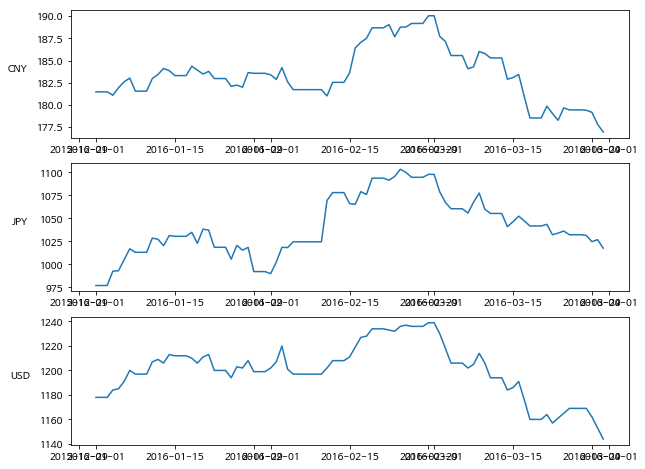

In [126]:
#STEP2. 변동추세확인- 시간에 따른 환율 추세 그래프생성
# 중국 위엔화, 엔화, 달러의 크기가 다르기 때문에 각각 그래프를 생성 / 3행1열, 크기:10,8
fig,(ax1,ax2,ax3)= plt.subplots(nrows= 3,ncols= 1, figsize = (10,8))
#zip 함수를 사용하면 zip함수 안의 리스트들을 하나씩 배출
# 1번loop :ax1, 311, "CNY"
# 2번loop :ax2, 312, "JPY"
# 3번loop :ax3, 313, "USD"
for(ax,idx,currency) in zip([ax1,ax2,ax3],[311,312,313],["CNY","JPY","USD"]):
    #plot 추가, 311 -> 3행 1열의 1번 그래프
    ax.plot("APPL_DATE","STD_RATE",data = df_currency[df_currency["CURRENCY"]==currency])
    ax.set_ylabel(currency,rotation = 0, labelpad = 20)


In [127]:
#CNY 데이터 추출 후 APPL_DATE를 INDEX로 설정
df_currency_cny= df_currency[df_currency["CURRENCY"]=="CNY"].set_index("APPL_DATE")
#drop method를 이용하여 통화(currency)와 미달러 환산율(USD_CONV_DATE)변수제외
df_currency_cny.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace = True)
#JPY데이터 생성
df_currency_jpy = df_currency[df_currency["CURRENCY"] == "JPY"].set_index("APPL_DATE")
df_currency_jpy.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace = True)
#USD데이터 생성
df_currency_usd = df_currency[df_currency["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_currency_usd.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace = True)
df_currency_cny.head()
# 중국위엔화환율데이터

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


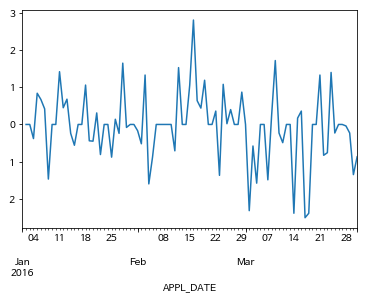

In [128]:
#STEP3.시계열 분석: 데이터 분할 - 차분을 통하여 정상성 데이터로 변화
# 1번차분:z(t)- z(t-1)
# shift(n): 앞의 n번 째 행의 데이터를 가져옴
df_cny_diff1 = df_currency_cny["STD_RATE"] - df_currency_cny["STD_RATE"].shift(1)
df_cny_diff1.plot()


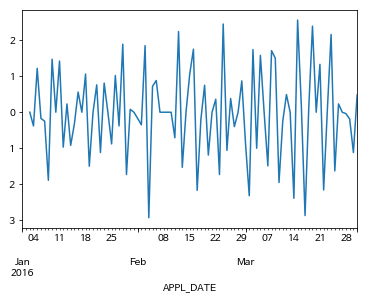

In [129]:
#2번차분 (z(t)-z(t-1))-(z(t-1)-z(t-2)) = z(t)-2*z(t-1) +z(t-2)
df_cny_diff2 = df_currency_cny["STD_RATE"]-2*(df_currency_cny["STD_RATE"].shift(1))+\
    (df_currency_cny["STD_RATE"].shift(2))

df_cny_diff2.plot()


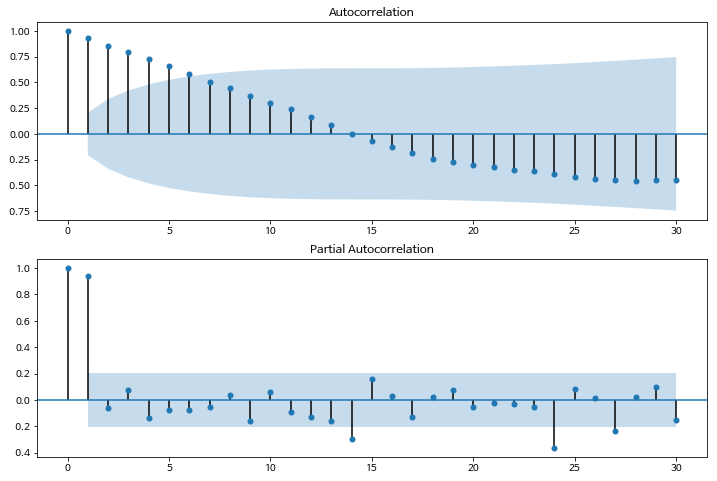

In [130]:
#STEP 3. 시계열분석 - 자기상관 함수 및 부분 자기상관함수
# LAG를 30까지 하여 ACF,PACF산출
lag_size = 30
fig = plt.figure(figsize = (12,8))
# acf 그래프를 그릴 공간 생성
ax1= fig.add_subplot(211)
# 자기상관 함수 그래프 plot_acf함수 사용 -> 위에 생성한 공간에 그래프 넣기
fig = plot_acf(df_currency_cny["STD_RATE"],lags = lag_size, ax = ax1)
#pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)
# 부분 자기상관 함수 그래프 plot_pacf 함수사용 -> 위에 생성한 공간에 그래프넣기
fig = plot_pacf(df_currency_cny["STD_RATE"],lags = lag_size, ax = ax2)



In [131]:
#AR(1),l(2, 차분),MA(0)인 ARIMA모델
#MA(0)인 이유: 평균을 낼 구간이 현재시점에서 과거 한시점밖에 없으므로 MA가 필요없다
ts_model_cny = ARIMA(df_currency_cny,order = (1,2,0))
#데이터 적합
# trend:상수포함 여부 "nc"이면 상수 미포함, full_output:모든 출력 결과 표시, disp : 수렴정보 출력
ts_result_cny = ts_model_cny.fit(trend= "c",full_output=True,disp = 1)
print(ts_result_cny.summary())
# 절편은 유의하지 않더라도 모델에 포함


                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   89
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -135.890
Method:                       css-mle   S.D. of innovations              1.113
Date:                Thu, 14 Feb 2019   AIC                            277.779
Time:                        01:21:31   BIC                            285.245
Sample:                    01-03-2016   HQIC                           280.788
                         - 03-31-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0115      0.083     -0.138      0.890      -0.174       0.151
ar.L1.D2.STD_RATE    -0.4273      0.095     -4.501      0.000      -0.613      -0.241
                        

C:\Users\znzla\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\znzla\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\znzla\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\znzla\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


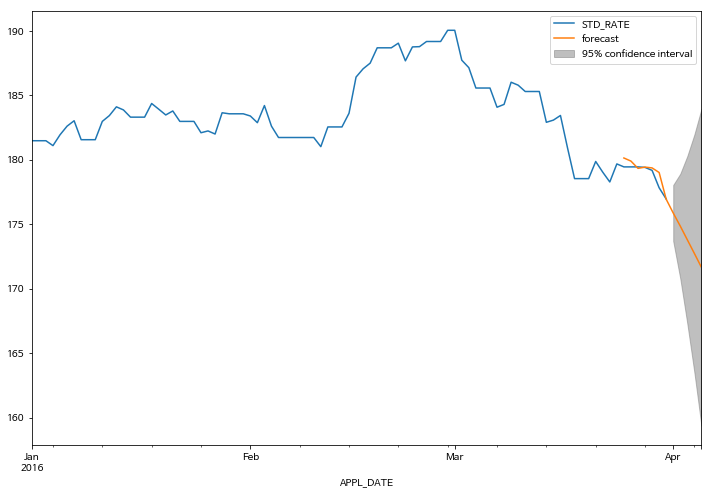

In [132]:
#STEP 4. 예측 및 결과 해석
#예측 시작 날짜 생성: "날짜",format
start_time = datetime.strptime("2016-03-25T00:00:00","%Y-%m-%dT%H:%M:%S")
end_time = datetime.strptime("2016-04-05T00:00:00","%Y-%m-%dT%H:%M:%S")
fig,ax = plt.subplots(figsize =(12,8))
# 예측 전까지 데이터
ax = df_currency_cny.plot(ax = ax)
# 예측 그래프 생성함수, start:예측시작,end:예측종료, plot_insample:가지고 있는 데이터 중 예측 구간과 겹치는 구간표시
fig = ts_result_cny.plot_predict(start = start_time, end = end_time, ax = ax,plot_insample=False)

